# Model for predicting radar fraction with different intensity bands

In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# %load_ext tensorboard

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model

In [5]:
import mlflow
mlflow.tensorflow.autolog()

2022/08/25 14:07:52 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [6]:
import prd_pipeline

In [7]:
import azureml.core
from azureml.core import Workspace, Datastore, Dataset
from azureml.core import Experiment

prd_ws = Workspace.from_config()

In [8]:
mlflow.set_tracking_uri(prd_ws.get_mlflow_tracking_uri())

In [10]:
azure_dataset_name ='prd_merged_all_events_files'
azure_experiment_name='prd_fraction_models'
azure_env_name = 'prd_ml_cluster'
cluster_name = 'mlops-test'

In [11]:
prd_model_name = 'azml_mlflow_20220504'

### Load data

In [12]:
target_parameter = 'rainfall_rate_composite'
profile_features = ['air_temperature', 'relative_humidity']
single_lvl_features = ['air_pressure_at_sea_level'] 

In [13]:
# input_data = prd_pipeline.load_data(
#     prd_ws,
#     dataset_name=azure_dataset_name
# )
# data_splits, data_dims = prd_pipeline.preprocess_data(
#     input_data,
#     test_fraction=0.2,
#     feature_dict={'profile': profile_features, 'single_level': single_lvl_features,'target': target_parameter,},
#     test_savefn='prd_test.csv'  # TODO: update filename!
# )


AttributeError: 'FileDataset' object has no attribute 'to_pandas_dataframe'

In [ ]:
prd_merged_file_dataset_name = 'prd_merged_all_events_files'
train202208_dataset_all = azureml.core.Dataset.get_by_name(prd_ws, name=prd_merged_file_dataset_name)
with train202208_dataset_all.mount() as mount1:
    print('loading all data')
    prd_path_list = [p1 for p1 in pathlib.Path(mount1.mount_point).rglob('*csv') ]
    merged_df = pd.concat([pd.read_csv(p1) for p1 in prd_path_list])
    
test_fraction=0.2
df_train, df_test = prd_pipeline.random_time_space_sample(merged_df, test_fraction=test_fraction, random_state=np.random.RandomState(), sampling_columns = ['time', 'latitude', 'longitude'])
data_splits, data_dims_dict = prd_pipeline.preprocess_data(df_train, feature_dict, test_fraction=test_fraction/(1-test_fraction))

Not mounting as a volume: ArgumentError(InvalidArgument { argument: "arguments.path", expected: "Glob patterns inside the path are not supported by the volume mount.Path must be a direct path to the file or folder, or end with '/**' or '/**/*' to match the entire content of the volume.", actual: "REDACTED" }). 
Falling back to dataflow mount.
loading all data


In [ ]:
input_data[:2]

In [ ]:
nprof_features = data_dims['nprof_features'] 
nheights = data_dims['nheights']
nsinglvl_features = data_dims['nsinglvl_features']

In [14]:
exp1 = mlflow.create_experiment('prd_exp_azml_mlflow')
exp1

'f1ebd4da-78ee-4b70-9d2c-5b9c5fb75ea9'

In [15]:
exp1 = mlflow.get_experiment(exp1)

In [16]:
exp1

<Experiment: artifact_location='', experiment_id='f1ebd4da-78ee-4b70-9d2c-5b9c5fb75ea9', lifecycle_stage='active', name='prd_exp_azml_mlflow', tags={}>

In [17]:
import datetime
log_dir = 'log/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

In [18]:
tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# run tensorboard --logdir LOGDIRPATH from command line to launch 

In [19]:
# plt.figure(figsize=(10, 8))
# plt.scatter(data_splits['X_test'], y_pred, s=200, c='darkblue')
# plt.gca().plot([0, 300], [0, 300], ls="--", c=".3")
# plt.xlabel('Actual 3hr precip accumulation value')
# plt.ylabel('Predicted 3hr precip_accumulation value')
# plt.show()

In [20]:
import tempfile

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile_input (InputLayer)     [(None, 33, 2)]      0           []                               
                                                                                                  
 zero_padding1d_3 (ZeroPadding1  (None, 35, 2)       0           ['profile_input[0][0]']          
 D)                                                                                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 33, 32)       192         ['zero_padding1d_3[0][0]']       
                                                                                                  
 zero_padding1d_4 (ZeroPadding1  (None, 35, 32)      0           ['conv1d_3[0][0]']         

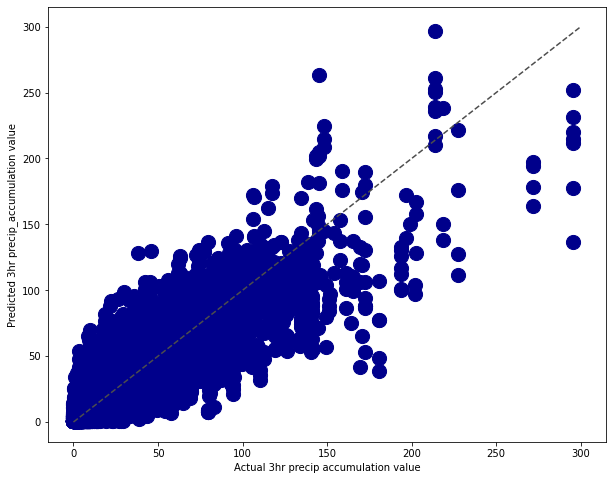

In [25]:
with mlflow.start_run(experiment_id=exp1.experiment_id) as current_run:
    model = prd_pipeline.build_model(nprof_features, nheights, nsinglvl_features)
    model.summary()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    history = model.fit(data_splits['X_train'], data_splits['y_train'], epochs=50, batch_size=128, validation_data=(data_splits['X_val'], data_splits['y_val']), verbose=True, callbacks=[tensorflow_callback])

    y_pred = model.predict(data_splits['X_val'])
    error = mean_absolute_error(data_splits['y_val'], y_pred)
    print(f'MAE: {error:.3f}')
    rsqrd = r2_score(data_splits['y_val'], y_pred)
    print(f'R-squared score: {rsqrd:.3f}')
    
    mlflow.log_metric('MAE', error)
    mlflow.log_metric('R-squared', rsqrd)
    
    fig1 = plt.figure(figsize=(10, 8))
    ax1 = fig1.add_subplot(1,1,1)
    ax1.scatter(data_splits['y_val'], y_pred, s=200, c='darkblue')
    ax1.plot([0, 300], [0, 300], ls="--", c=".3")
    ax1.set_xlabel('Actual 3hr precip accumulation value')
    ax1.set_ylabel('Predicted 3hr precip_accumulation value')
#     with tempfile.TemporaryDirectory() as td1:
        
#         fig1.savefig(plot_out_path, bbox_inches='tight')
    mlflow.log_figure(fig1,  'actual_predicted_precip_3hr.png')                   
    # mlflow.log


If we look at the experiment in AzureML GUI, we see that all the model parameters have been automatically logged, and the model has been saved by ML Flow ready for use in inference.

## Evaluation

In [26]:
training_hist_df = pd.DataFrame(history.history)
training_hist_df['epoch'] = history.epoch

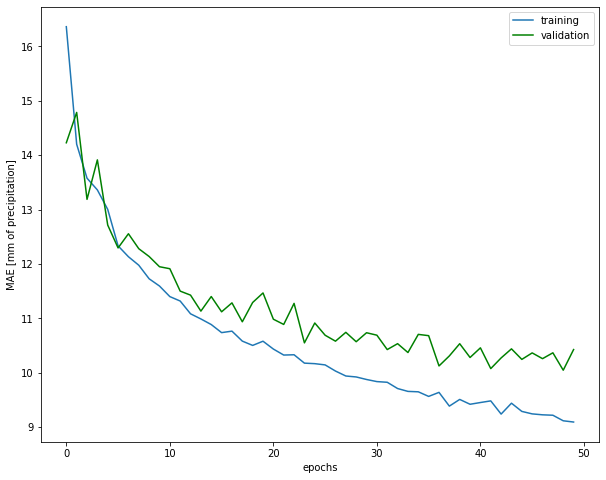

In [27]:
plt.figure(figsize=(10, 8))
plt.plot(training_hist_df.epoch, training_hist_df.loss, label='training')
plt.plot(training_hist_df.epoch, training_hist_df.val_loss, c='g', label='validation')
plt.legend()
plt.ylabel('MAE [mm of precipitation]')
plt.xlabel('epochs')
plt.show()

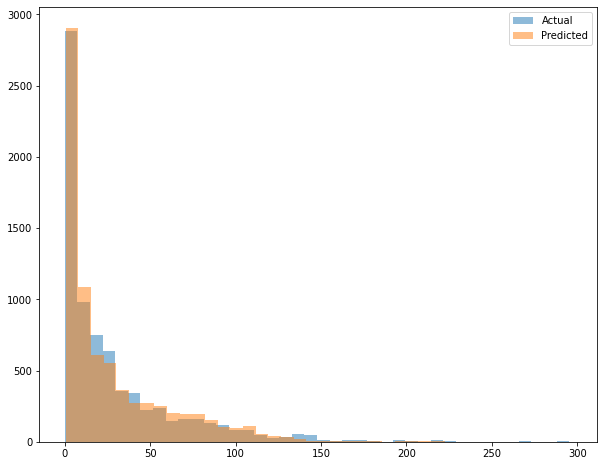

In [28]:
plt.figure(figsize=(10, 8))
plt.hist(data_splits['y_val'], alpha=0.5, bins=40, label='Actual')
plt.hist(y_pred, alpha=0.5, bins=40, label='Predicted')
plt.legend()
plt.show()